In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw, rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from multiprocessing import Pool
from functools import partial
from rdkit.Chem import rdFMCS
from collections import Counter


# 0. INPUT DATA
## 0.1 PREPARING DATA, FPs

0.1.1 choose input file

In [44]:
inputFile = "cluster_x_0515_y_-30-39.csv"

___

0.1.2 Create a list of RDKit compounds from SMILES, generate their fingerprints

In [45]:
smiles_act_df = pd.read_csv(inputFile)
smiles_act_df = smiles_act_df.loc[smiles_act_df["target_seq_label_1"].notna()].reset_index(drop=True) #smiles only with target_seq_label1
smiles_act_df

,SMILES,x,y,num_atoms,pca_components,smiles,target_seq_label_0,target_seq_label_1
0,C[C@H]1CC[C@H](Cn2c(N3CCOC[C@H]3c3ccccc3)nc3cc...,0.994178,-3.737984,43,0,C[C@H]1CC[C@H](Cn2c(N3CCOC[C@H]3c3ccccc3)nc3cc...,['MEALMARGALTGPLRALCLLGCLLSHAAAAPSPIIKFPGDVAPK...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
1,COc1ccc(CC(=O)O)cc1-c1cc2c(n1C(C)C)C(c1ccc(Cl)...,0.947667,-3.653722,40,0,COc1ccc(CC(=O)O)cc1-c1cc2c(n1C(C)C)C(c1ccc(Cl)...,['MAPLCPSPWLPLLIPAPAPGLTVQLLLSLLLLVPVHPQRLPRMQ...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
2,COc1ccc(C#N)cc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1)...,0.995698,-3.689250,37,0,COc1ccc(C#N)cc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1)...,['MRLLLALLGVLLSVPGPPVLSLEASEEVELEPCLAPSLEQQEQE...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
3,C[C@]1(CC(=O)O)C[C@H](c2cccc(Cl)c2)[C@@H](c2cc...,0.938458,-3.677047,36,0,C[C@]1(CC(=O)O)C[C@H](c2cccc(Cl)c2)[C@@H](c2cc...,['MAQTQGTRRKVCYYYDGDVGNYYYGQGHPMKPHRIRMTHNLLLN...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
4,CC[C@@H](CS(=O)(=O)C(C)(C)C)N1C(=O)[C@@](C)(Cc...,0.974929,-3.638394,39,0,CC[C@@H](CS(=O)(=O)C(C)(C)C)N1C(=O)[C@@](C)(Cc...,['MSSQSHPDGLSGRDQPVELLNPARVNHMPSTVDVATALPLQVAP...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
...,...,...,...,...,...,...,...,...
1893,COc1ccc(CO)cc1-c1cc2c(n1C(C)C)C(c1ccc(Cl)cc1C)...,0.960118,-3.656014,38,0,COc1ccc(CO)cc1-c1cc2c(n1C(C)C)C(c1ccc(Cl)cc1C)...,['MPPRPSSGELWGIHLMPPRILVECLLPNGMIVTLECLREATLIT...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
1894,CC[C@@H](CS(=O)(=O)C(C)(C)C)N1C(=O)[C@@](C)(CC...,0.962426,-3.651155,44,0,CC[C@@H](CS(=O)(=O)C(C)(C)C)N1C(=O)[C@@](C)(CC...,['MTFNSFEGSKTCVPADINKEEEFVEEFNRLKTFANFPSGSPVSA...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
1895,COc1ccncc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,0.994570,-3.684807,36,0,COc1ccncc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,['MRARPRPRPLWATVLALGALAGVGVGGPNICTTRGVSSCQQCLA...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...
1896,COc1ncccc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,0.996883,-3.689901,36,0,COc1ncccc1-c1nc2c(n1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,['MMDVNSSGRPDLYGHLRSFLLPEVGRGLPDLSPDGGADPVAGSW...,['MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQ...


In [46]:
compunds_act = []
for _, smiles in smiles_act_df["SMILES"].items():
    compunds_act.append(Chem.MolFromSmiles(smiles))

In [47]:
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024) #MorganFP, radius=2, size=1024bit
compunds_act_fps = [rdkitGen.GetFingerprint(mol) for mol in compunds_act]

print(f"Number of compunds_act converted: {len(compunds_act_fps)}")
print(f"Fingerprint length per compound: {len(compunds_act_fps[0])}")

Number of compunds_act converted: 1898
Fingerprint length per compound: 1024


___

0.1.3 Create a list of RDKit compounds without known activity from SMILES, generate their fingerprints

In [48]:
smiles_noact_df = pd.read_csv(inputFile)
smiles_noact_df = smiles_noact_df[smiles_noact_df["target_seq_label_1"].isna()].reset_index(drop=True) #smiles only without target_seq_label1
smiles_noact_df = smiles_noact_df.drop_duplicates(subset="SMILES", keep="first").reset_index(drop=True)
smiles_noact_df

,SMILES,x,y,num_atoms,pca_components,smiles,target_seq_label_0,target_seq_label_1
0,CC(=O)C(C)(C)Oc1ccc(Br)cc1C1CC(=O)NC(c2cc(F)cc...,1.000500,-3.542459,39,0,NaN,NaN,NaN
1,CCC(C[NH+]1CCOCC1)N1C(=O)C(C)(CC=O)CC(c2cccc(C...,0.964414,-3.525806,35,0,NaN,NaN,NaN
2,CCN(C(=O)c1ccccc1O)C(C(=O)Nc1c(C)cccc1C)c1ccc(...,0.991655,-3.454957,32,0,NaN,NaN,NaN
3,CCc1cccc(N(P(c2ccccc2)c2ccccc2)P(c2ccccc2)c2cc...,0.949562,-3.419487,35,0,NaN,NaN,NaN
4,COc1cccc(Cn2cnc(c3ccccc3OC)c2c2cccs2)c1,0.983207,-3.318728,27,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9362,COc1ccccc1n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1)N(c1cc...,0.991443,-3.638764,40,0,NaN,NaN,NaN
9363,COC(=O)c1cc(c2ccc([N+](=O)[O-])cc2)n(c2ccc(C)c...,0.987426,-3.528230,29,0,NaN,NaN,NaN
9364,COc1ccc(C(C(=O)NCCC(C)C)N(Cc2ccc3c(c2)OCO3)C(=...,1.031282,-3.092687,40,0,NaN,NaN,NaN
9365,C=CCN(C(=O)C(CC(C)C)NC(=O)OC(C)(C)C)C(C(=O)NC1...,1.021050,-3.519727,37,0,NaN,NaN,NaN


In [49]:
compunds_noact = []
for _, smiles in smiles_noact_df["SMILES"].items():
    compunds_noact.append(Chem.MolFromSmiles(smiles))

In [50]:
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fingerprintsNoAct = [rdkitGen.GetFingerprint(mol) for mol in compunds_noact]

print(f"Number of compounds (activity unknown)) converted: {len(fingerprintsNoAct)}")
print(f"Fingerprint length per compound: {len(fingerprintsNoAct[0])}")

Number of compounds (activity unknown)) converted: 9367
Fingerprint length per compound: 1024


___________

# 1. CLUSTERING BY SIMILARITY/DISTANCE
## 1.1 DEFINING CLUSTERS, DEFINING CENTROIDS

In [51]:
def tanimotoDistanceMatrix(fpList):
    """
    generate Tanimoto distance matrix
    input: list of fingerprints
    output: matrix of distances between each molecule
    """
    dissimilarityMatrix = []
    for i in range (1, len(fpList)):
        similarities = DataStructs.BulkTanimotoSimilarity(fpList[i], fpList[:i])
        dissimilarityMatrix.extend([1 - x for x in similarities])
    return dissimilarityMatrix

def clusterFingerprints(fingerprints, cutoff):
    """cluster fingerprints using Butina based on pre-set cutoff
    input: list of fingerprints, cutoff[0;1]
    output: a tuple of tuples containing information about the clusters; first element for each cluster is its centroid
    *higher cutoff = less clusters, bigger diversity within a cluster
    """
    distanceMatrix = tanimotoDistanceMatrix(fingerprints)
    clusters = Butina.ClusterData(distanceMatrix, len(fingerprints), cutoff, isDistData = True)
    clusters = sorted(clusters, key = len, reverse = True)
    return clusters

Test different cutoffs

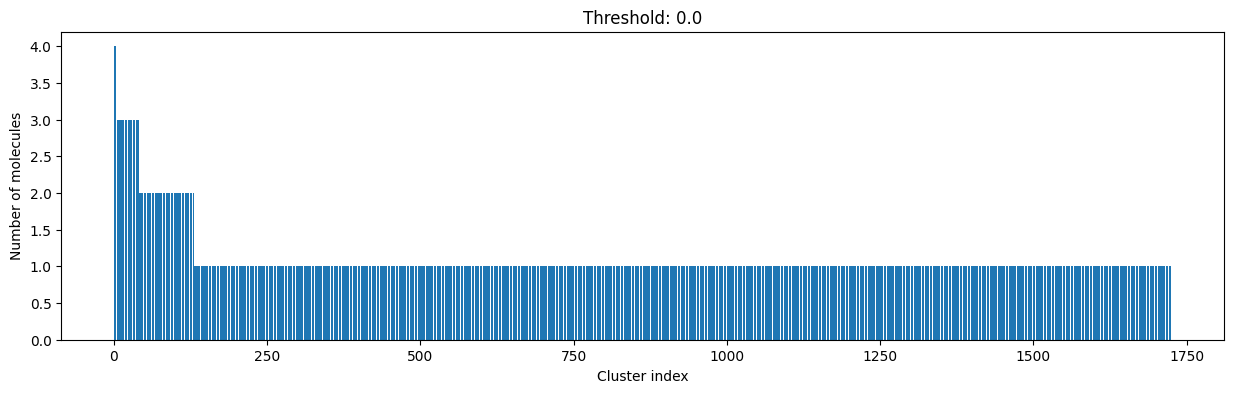

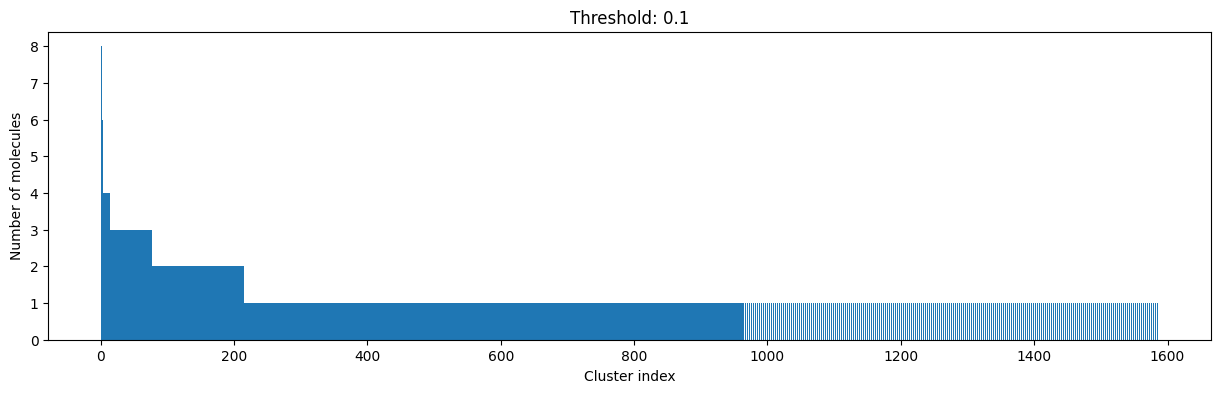

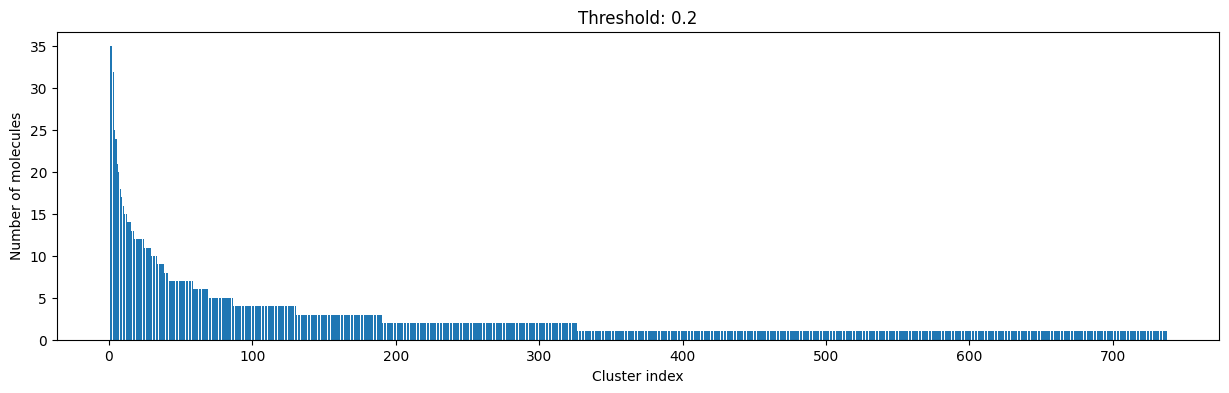

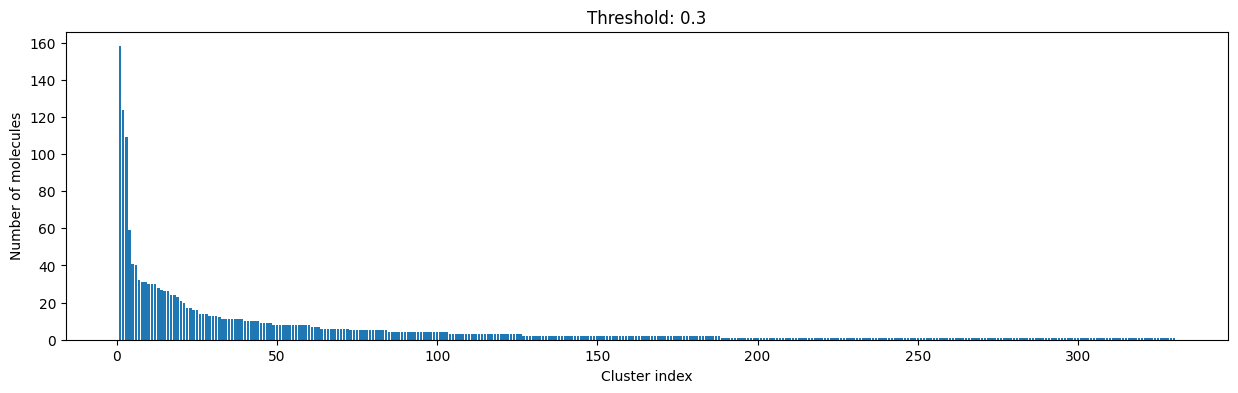

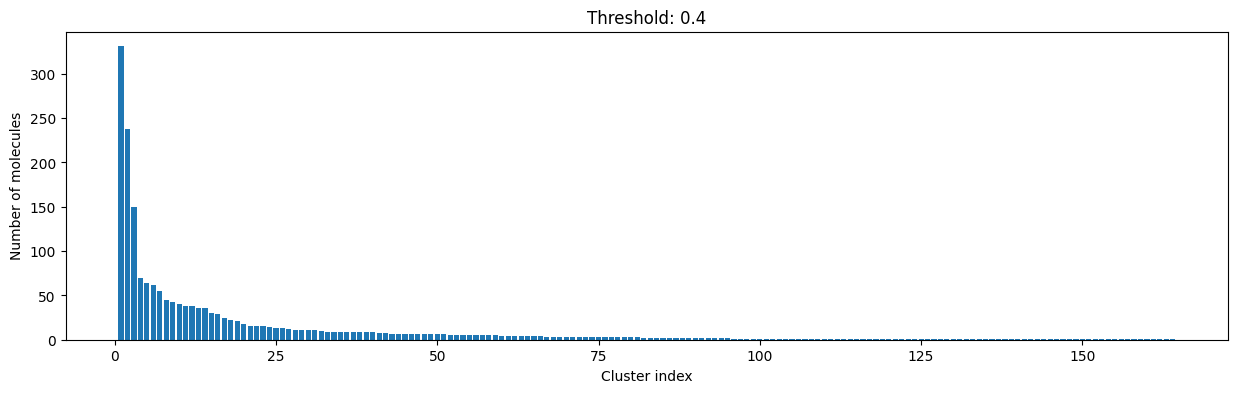

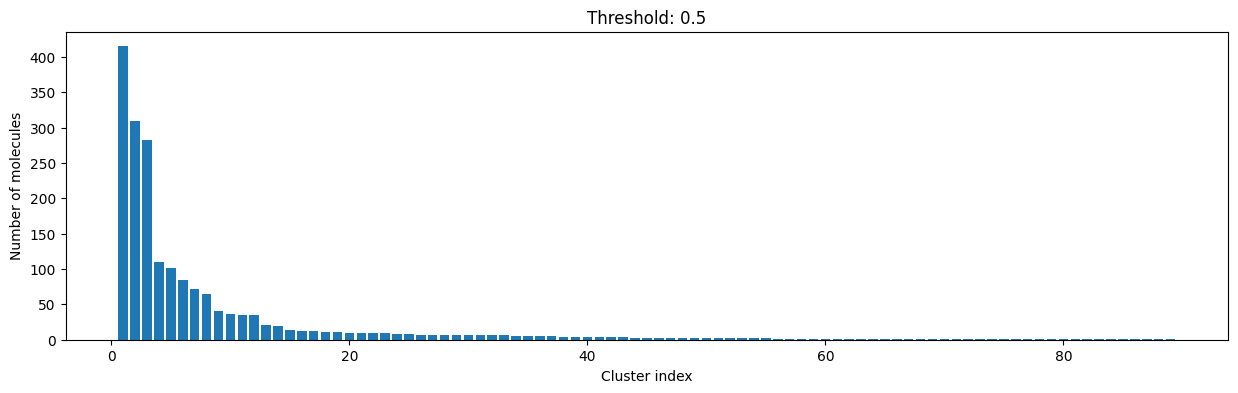

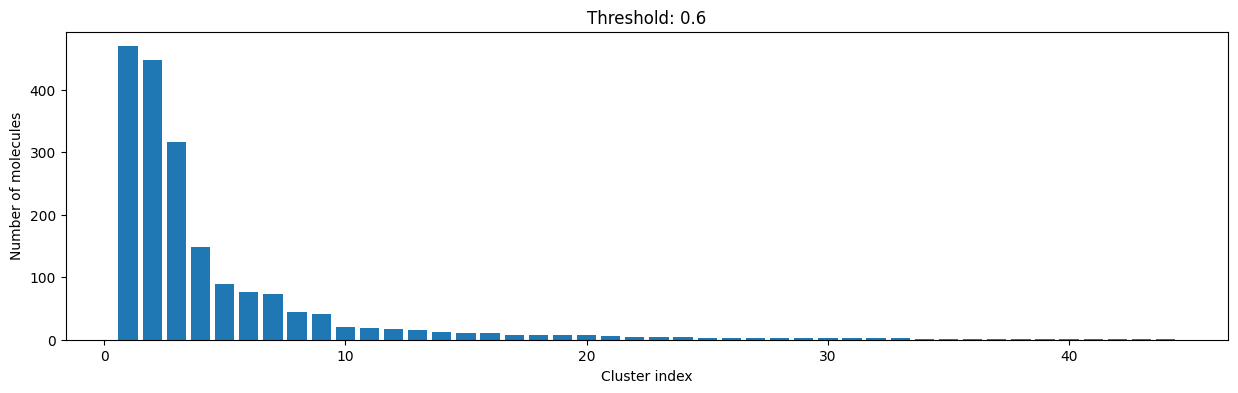

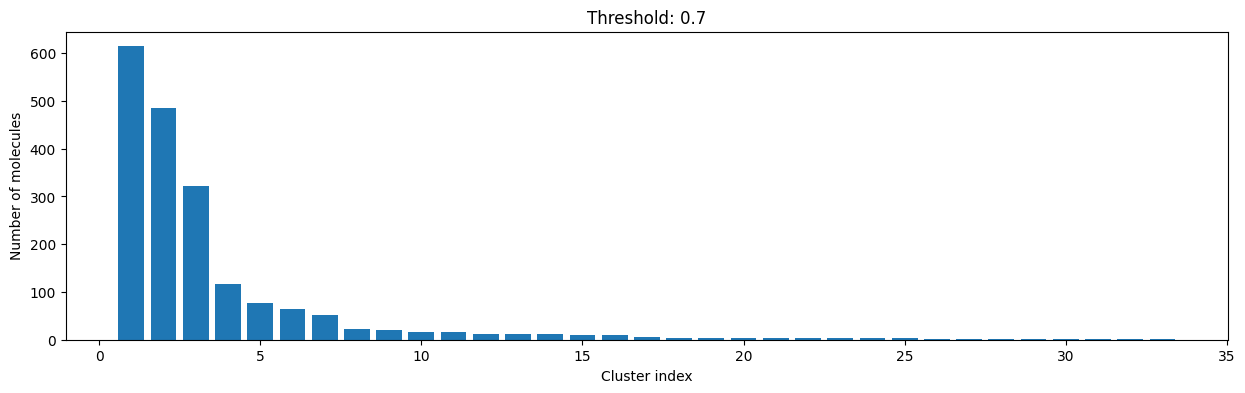

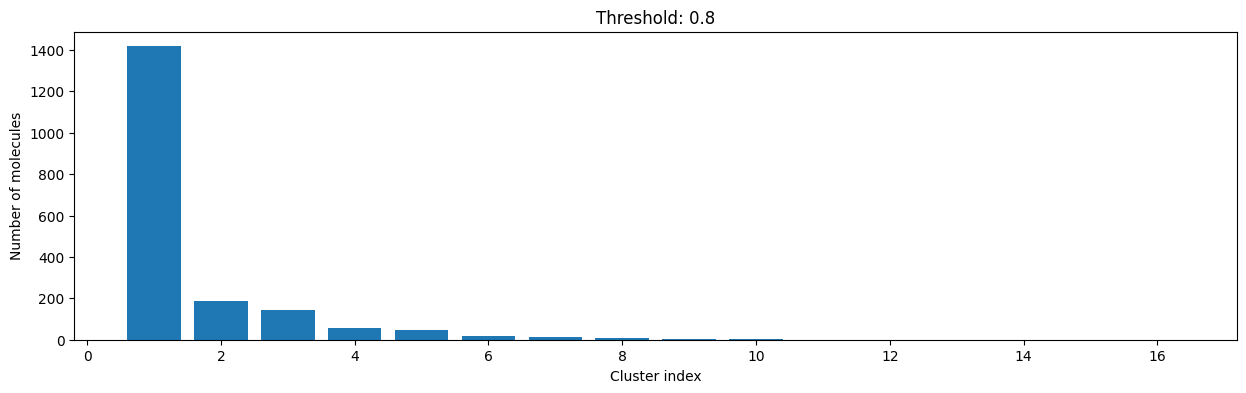

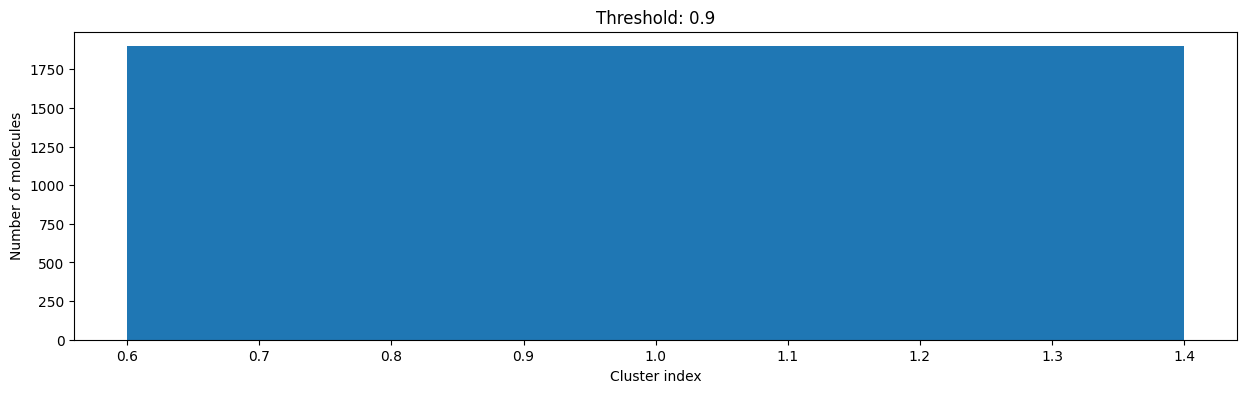

In [52]:
for cutoff in np.arange(0.0, 1.0, 0.1):
    clusters = clusterFingerprints(compunds_act_fps, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

In [78]:
cutoff = 0.6 #elements within this range of each other are considered to be neighbors
compunds_act_clusters = clusterFingerprints(compunds_act_fps, cutoff = cutoff)

Compounds distribution, clusters specification

In [79]:
print("total # clusters: ", len(compunds_act_clusters))
print(f"# clusters with only 1 compound: {sum(1 for c in compunds_act_clusters if len(c) == 1)}")
print(f"# clusters with >5 compounds: {sum(1 for c in compunds_act_clusters if len(c) > 5)}")
print(f"# clusters with >25 compounds: {sum(1 for c in compunds_act_clusters if len(c) > 25)}")
print(f"# clusters with >100 compounds: {sum(1 for c in compunds_act_clusters if len(c) > 100)}")

total # clusters:  44
# clusters with only 1 compound: 11
# clusters with >5 compounds: 21
# clusters with >25 compounds: 9
# clusters with >100 compounds: 4


In [80]:
smiles_act_df["cluster"] = np.nan
for indice in range(len(compunds_act_clusters)):
   for registro in compunds_act_clusters[indice]:
       smiles_act_df.loc[registro, "cluster"] = indice

smiles_df = smiles_act_df[smiles_act_df["SMILES"].notna()]
smiles_df = smiles_df.sort_values(by=["cluster"], ascending=True).reset_index(drop=True)
smiles_df_2 = smiles_df[["SMILES", "cluster"]]
smiles_df_2

,SMILES,cluster
0,CN(C1CC1)S(=O)(=O)C[C@@H](N1C(=O)[C@@](C)(CC(=...,0.0
1,CC[C@@H](CS(=O)(=O)NCC1COC1)N1C(=O)[C@@](C)(CC...,0.0
2,CC[C@@H](CS(=O)(=O)C(C)(C)C)N1C(=O)[C@@](C)(CC...,0.0
3,CCS(=O)(=O)NC[C@H](C1CC1)N1C(=O)[C@@](C)(CC(=O...,0.0
4,CC[C@@H](c1cc(C)ccn1)N1C(=O)[C@@](C)(CC(=O)O)C...,0.0
...,...,...
1893,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1,39.0
1894,CC(C)c1c(C(=O)N[C@H]2CCCC[C@@H]2O)nc(-c2ccccc2...,40.0
1895,O=c1oc2ccccc2cc1-c1cn(-c2ccccc2)c(S)n1,41.0
1896,Cc1c(Cl)ccc2c(CC3=NC(=O)N(C(C(=O)NC(CO)CO)c4cc...,42.0


Dictionary of clusters as keys and SMILES as values

In [81]:
dictOfClusters = {key: value["SMILES"].tolist() for key, value in smiles_df_2.groupby("cluster")}

List of representatives/centroids

In [82]:
representatives = [values[0] for values in dictOfClusters.values()]

Create a list of representative RDKit compounds(cluster centroids) from SMILES, generate their fingerprints

In [83]:
representativesMol = []
for representative in representatives:
    representativesMol.append(Chem.MolFromSmiles(representative))

In [84]:
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fingerprintsRepresentatives = [rdkitGen.GetFingerprint(mol) for mol in representativesMol]

print(f"Number of compounds (representatives) converted: {len(fingerprintsRepresentatives)}") #number of representatives = number of clusters
print(f"Fingerprint length per compound: {len(fingerprintsRepresentatives[0])}")

Number of compounds (representatives) converted: 44
Fingerprint length per compound: 1024


__________

## 1.2 CLUSTERING COMPOUNDS W/O KNOWN ACTIVITY

In [85]:
def assignToNearestRepresentative(fingerprintsRepresentatives, fingerprintsNoAct, cutoff):
    """
    calculate distances between each representative and smiles without seq_label_1
    """
    assignments = []
    
    for i, noActFP in enumerate(fingerprintsNoAct):
        bestReprID = -1
        bestSimilarity = -1
        
        for reprID, reprFP in enumerate(fingerprintsRepresentatives):
            similarity = DataStructs.TanimotoSimilarity(noActFP, reprFP)
            
            if similarity > bestSimilarity and (1 - similarity) <= cutoff:
                bestSimilarity = similarity
                bestReprID = reprID
        
        assignments.append({
            "noact_index": i,
            "representative_index": bestReprID,
            "similarity": bestSimilarity,
            "distance": 1 - bestSimilarity
        })
    
    return assignments

Test different cutoffs

In [86]:
#higher cutoff means smaller similarity between molecules needed to assign them to a representative
#per RDK: cutoff - elements within this range of each other are considered to be neighbors
for cutoff in np.arange(0.0, 1.0, 0.2):
    assignments = assignToNearestRepresentative(fingerprintsRepresentatives, fingerprintsNoAct, cutoff=cutoff)
    
    assigned_count = len([a for a in assignments if a["representative_index"] != -1])
    unassigned_count = len(assignments) - assigned_count
    
    print(f"cutoff = {cutoff}")
    print(f"assigned particles: {assigned_count}")
    print(f"unassigned particles: {unassigned_count}")

cutoff = 0.0
assigned particles: 0
unassigned particles: 9367
cutoff = 0.2
assigned particles: 8
unassigned particles: 9359
cutoff = 0.4
assigned particles: 89
unassigned particles: 9278
cutoff = 0.6000000000000001
assigned particles: 1095
unassigned particles: 8272
cutoff = 0.8
assigned particles: 7883
unassigned particles: 1484


In [87]:
#how many clusters + df + dict
cutoff = 0.35
assignments = assignToNearestRepresentative(fingerprintsRepresentatives, fingerprintsNoAct, cutoff=cutoff)
results_df = pd.DataFrame(assignments)

grouped_assignments = {}
for i, assignment in enumerate(assignments):
    if assignment["representative_index"] != -1:
        rep_idx = assignment["representative_index"]
        if rep_idx not in grouped_assignments:
            grouped_assignments[rep_idx] = []
        grouped_assignments[rep_idx].append({
            "noact_index": i,
            "smiles": smiles_noact_df.iloc[i]["SMILES"],
            "similarity": assignment["similarity"]
        })

print(f"generated {len(grouped_assignments)} clusters")
#grouped_assignments

generated 19 clusters


Generate a side list of lists of compounds to help with indexing

In [88]:
assigned_particles_by_representative = [[] for _ in range(len(representatives))]
for assignment in assignments:
    rep_idx = assignment["representative_index"]
    if rep_idx != -1:
        assigned_particles_by_representative[rep_idx].append(smiles_noact_df.iloc[assignment["noact_index"]]["SMILES"])
#assigned_particles_by_representative

Visualize the clusters - draw representative + assigned compounds

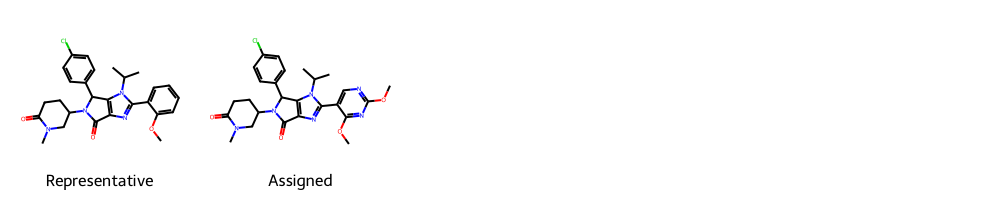

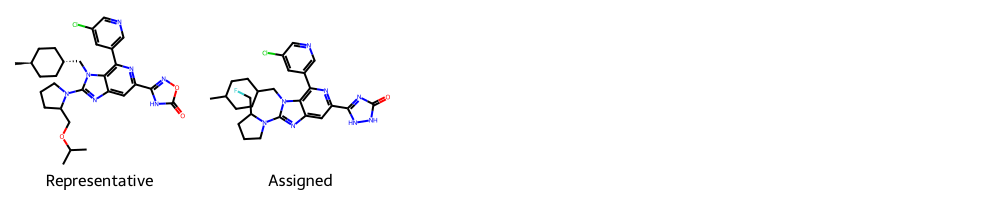

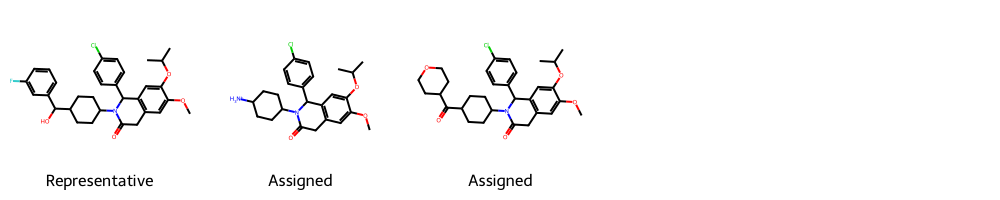

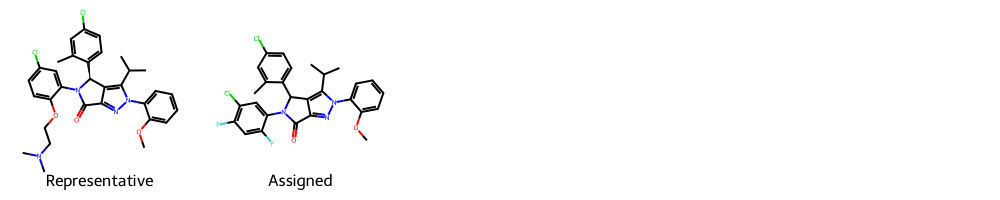

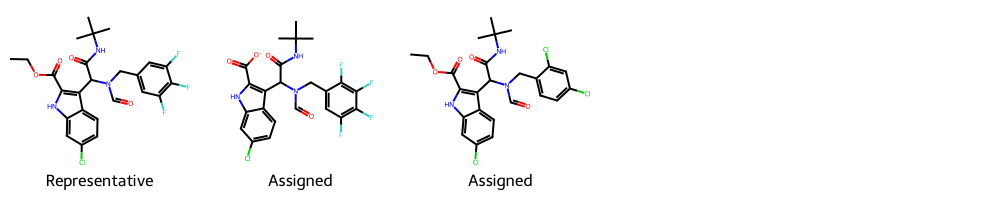

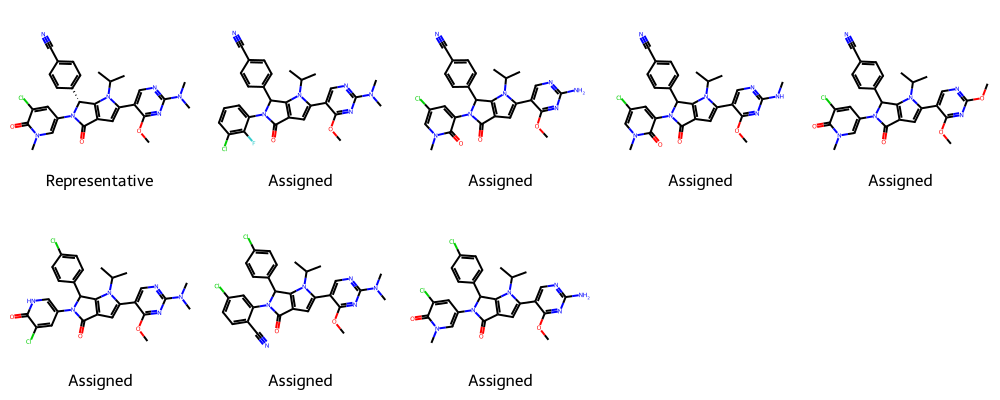

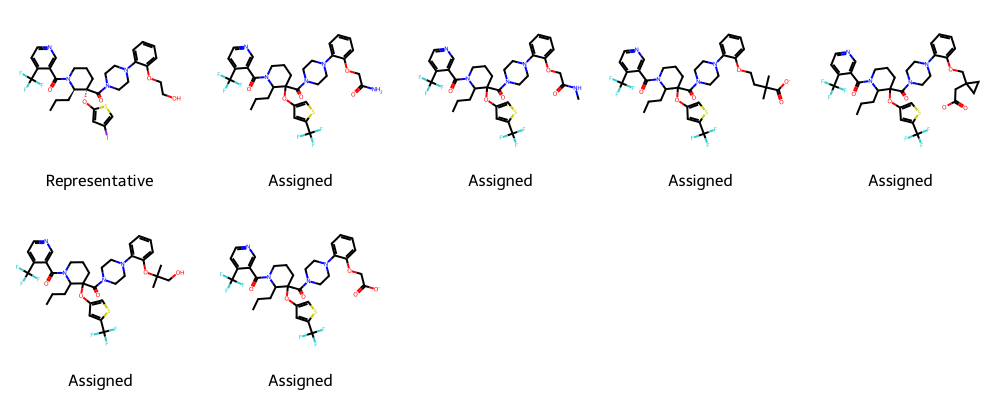

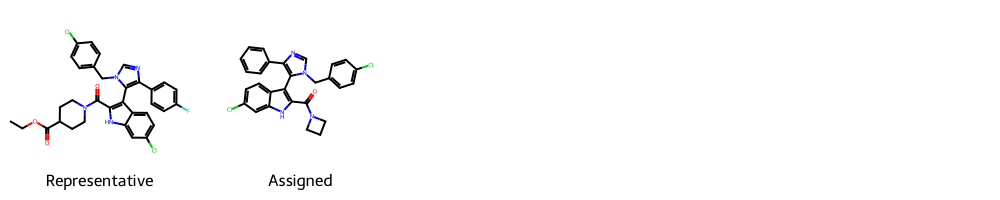

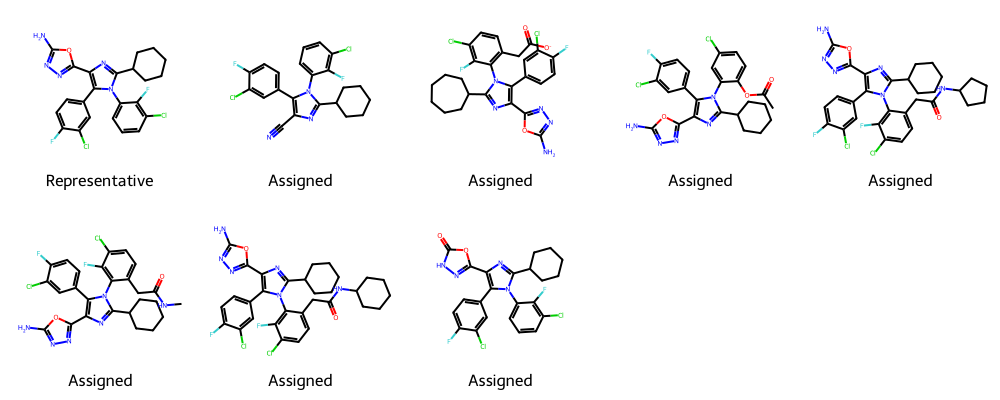

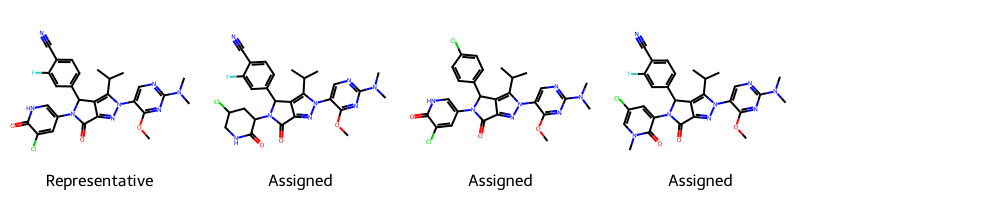

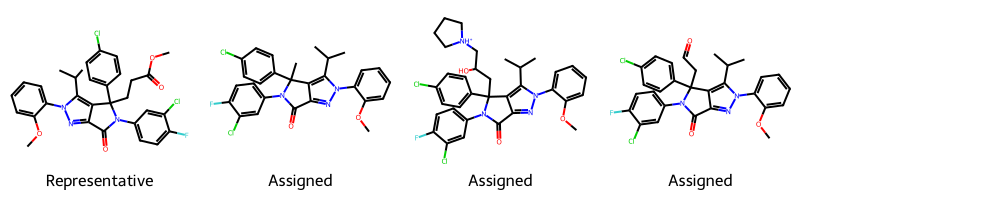

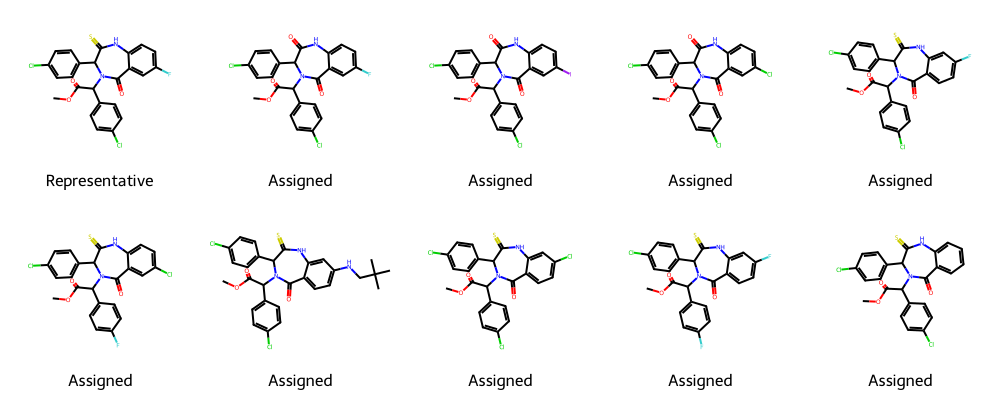

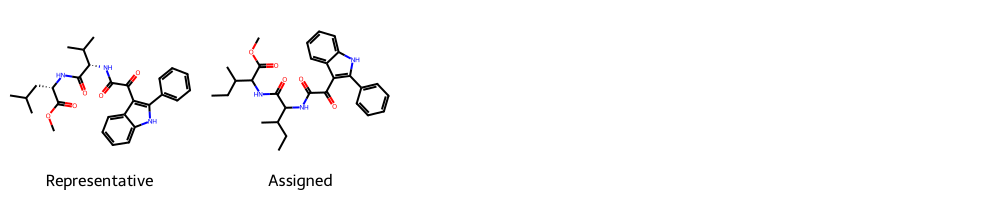

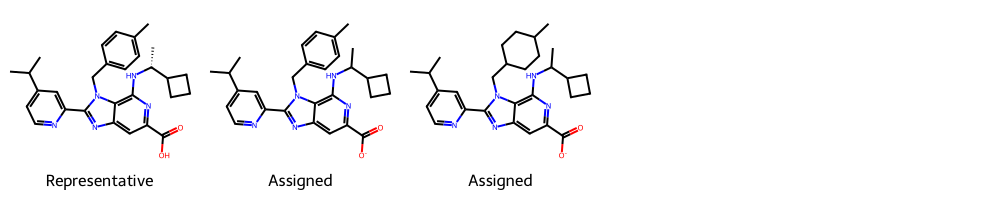

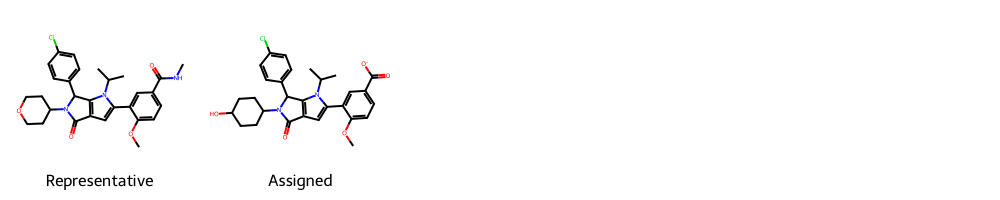

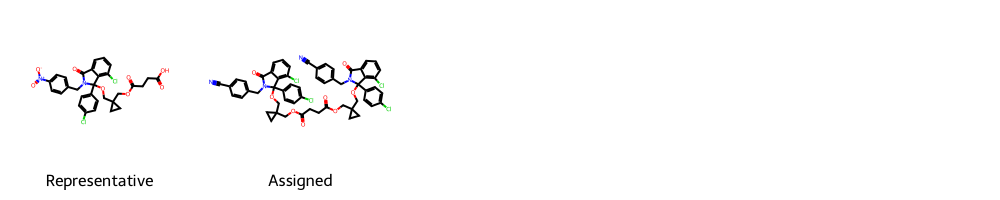

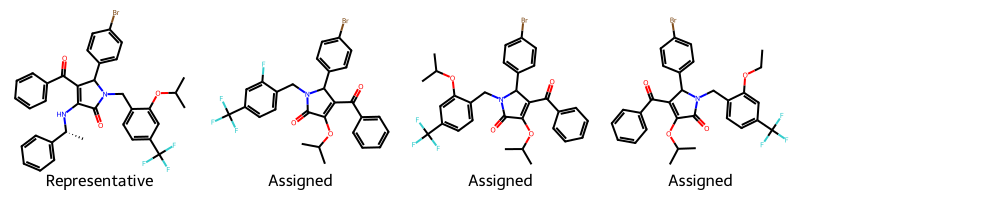

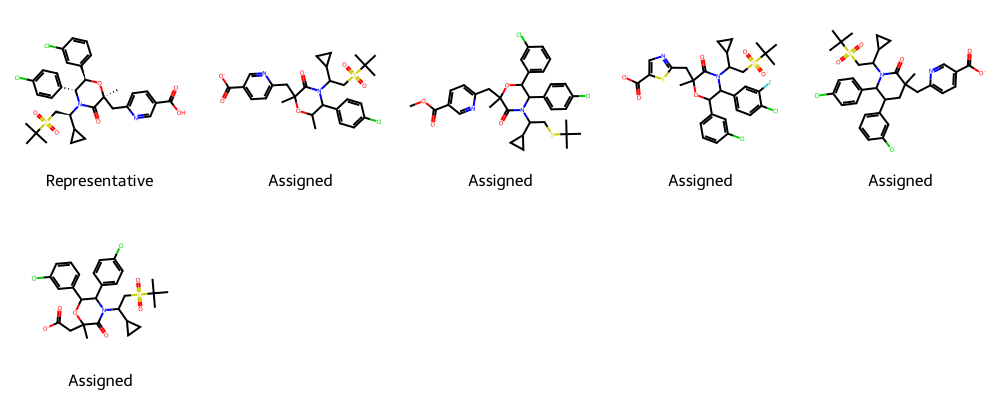

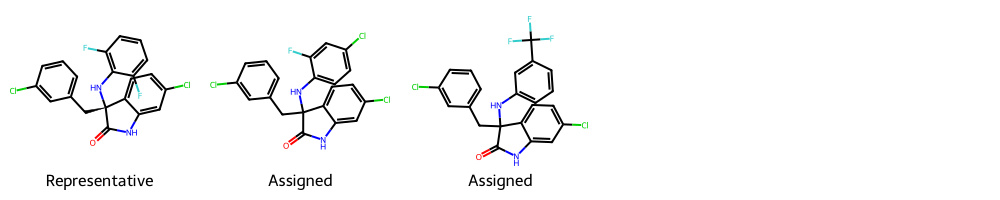

In [89]:
for rep_idx, smiles_list in enumerate(assigned_particles_by_representative):
    rep_mol = representativesMol[rep_idx]
    if smiles_list:
        assigned_mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    else:
        continue
    mols_to_draw = [rep_mol] + assigned_mols
    img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(200,200), legends=["Representative"] + ["Assigned"]*len(assigned_mols))
    display(img)

In [93]:
#df smiles + x, y + cluster ID
cutoff = 0.6
assignments = assignToNearestRepresentative(fingerprintsRepresentatives, fingerprintsNoAct, cutoff=cutoff)
data = []

for assignment in assignments:
    if assignment["representative_index"] != -1:
        noact_idx = assignment["noact_index"]
        smiles = smiles_noact_df.iloc[noact_idx]["SMILES"]
        cluster_idx = assignment["representative_index"]
        
        data.append({
            "SMILES": smiles,
            "cluster_index": cluster_idx
        })
    
out_df = pd.DataFrame(data)
    
original_coords = pd.read_csv("cluster_x_0515_y_-30-39.csv")[["SMILES", "x", "y"]]
result_df = out_df.merge(original_coords, on="SMILES", how="left")
    
result_df = result_df[["SMILES", "x", "y", "cluster_index"]]
result_df

,SMILES,x,y,cluster_index
0,CC(=O)C(C)(C)Oc1ccc(Br)cc1C1CC(=O)NC(c2cc(F)cc...,1.000500,-3.542459,27
1,CCC(C[NH+]1CCOCC1)N1C(=O)C(C)(CC=O)CC(c2cccc(C...,0.964414,-3.525806,0
2,CCNC(=O)C[NH2+]C1CCC(NN(C)c2ccc(N3C(=O)Cc4cc(O...,0.994050,-3.604691,5
3,C=C(O)CCCC(C)Oc1ccccc1C1(C#N)CCN(C(=O)C2(Oc3cs...,0.998545,-3.545042,9
4,C=CCC1(C)CC(c2cccc(Cl)c2)C(c2ccc(Cl)cc2)N(C(CC...,0.955886,-3.511566,0
...,...,...,...,...
1090,CC1CCC(Cn2c(N3CCCC3C3CN(C)N=N3)nc3cc(c4nc(=O)o...,0.998668,-3.666509,2
1091,Cc1cc(NC2(Cc3cccc(Cl)c3)C(=O)Nc3cc(Cl)ccc32)cc...,1.010975,-3.449089,36
1092,CCOC(c1cccnc1)c1nc2cc(C3NOC(=O)N3)nc(c3cncc(Cl...,1.018515,-3.668080,2
1093,COc1cc2c(cc1OC(C)C)C(c1ccc(Cl)cc1)N(c1ccc(C(C)...,0.996981,-3.578060,5


Plot compounds:
x,y predicted by model, 
colored by distance/similarity assigned cluster

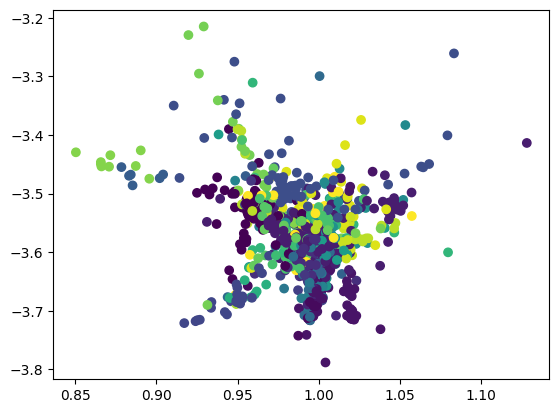

In [94]:
x = result_df["x"]
y = result_df["y"]
plt.scatter(x, y, c=result_df["cluster_index"])
plt.show()

____________

# 2. CLUSTERING BY SCAFFOLDS
## 2.1 DEFINING CLUSTERS, DEFINING CENTROIDS

In [67]:
smiles_noact = smiles_noact_df["SMILES"].tolist()
smiles_act = smiles_act_df["SMILES"].tolist()

In [68]:
def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    else:
        return None

In [95]:
scaffolds_noact = []
for noAct in smiles_noact:
    scaffold = get_scaffold(noAct)
    scaffolds_noact.append(scaffold)

scaffolds_representatives = []
for representative in representatives:
    scaffold = get_scaffold(representative)
    scaffolds_representatives.append(scaffold)

In [102]:
def assign_to_scaffold_representative(smiles_noact, scaffolds_noact, scaffolds_representatives):
    assignments = []
    for idx, scaffold in enumerate(scaffolds_noact):
        if scaffold is not None and scaffold in scaffolds_representatives:
            rep_idx = scaffolds_representatives.index(scaffold)
        else:
            rep_idx = -1
        assignments.append({
            "smiles": smiles_noact[idx],
            "representative_index": rep_idx,
            "scaffold": scaffold
        })
    return assignments

scaffold_assignments = assign_to_scaffold_representative(smiles_noact, scaffolds_noact, scaffolds_representatives)

Filter out compounds not assigned to any cluster

In [103]:
filtered_scaffold_assignments = [a for a in scaffold_assignments if a["representative_index"] != -1]

In [104]:
inactive_smiles = [a["smiles"] for a in filtered_scaffold_assignments]

smiles_to_rep_idx = {a["smiles"]: a["representative_index"] for a in filtered_scaffold_assignments}

df_scaffold_xy = smiles_noact_df.loc[smiles_noact_df["SMILES"].isin(inactive_smiles), ["SMILES", "x", "y"]]
df_scaffold_xy["representative_index"] = df_scaffold_xy["SMILES"].map(smiles_to_rep_idx)
df_scaffold_xy.reset_index(drop=True, inplace=True)
df_scaffold_xy

,SMILES,x,y,representative_index
0,Cc1ccc(Cn2c(c3cc(C(C)C)ccn3)nc3cc(C(=O)[O-])nc...,1.004898,-3.644533,20
1,CCC(C)N(C(=O)C(=O)c1c2ccccc2[nH]c1c1ccccc1)C(C)CC,1.030072,-3.584486,19
2,COC(=O)c1c2ccccc2[nH]c1c1ccc(C)cc1,1.006091,-3.556460,19
3,COC(=O)c1c2ccccc2[nH]c1c1ccccc1,1.002037,-3.577380,19
4,CC(C)(C)NC(=O)C(c1c(C(=O)[O-])[nH]c2cc(Cl)ccc1...,0.998864,-3.666407,7
5,COc1ncc(n2nc3c(c2C(C)C)C(c2ccc(Cl)c(F)c2)N(c2c...,0.997096,-3.652899,15
6,COc1ccccc1n1nc2c(c1C(C)C)C(C)(c1ccc(Cl)cc1)N(c...,0.995332,-3.614756,17
7,CC(=O)Oc1ccc(Cl)cc1n1c(C2CCCCC2)nc(c2nnc(N)o2)...,1.001549,-3.587880,13
8,C=C(C)c1ccc2c(c1)C(=O)N(Cc1ccc(Cl)cc1)C2(OCC1(...,0.990970,-3.589421,26
9,COc1ccccc1n1nc2c(c1C(C)C)C(c1ccc(F)cc1)N(c1ccc...,0.996054,-3.656243,17


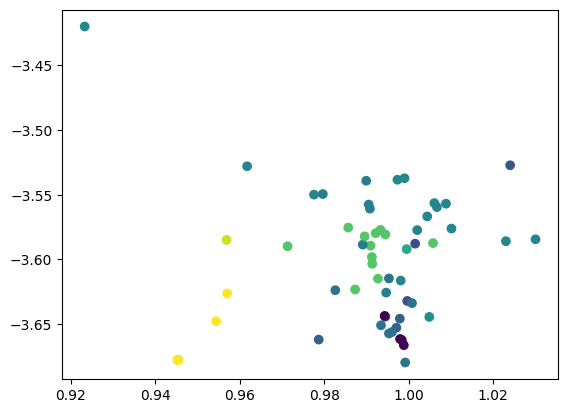

In [105]:
x = df_scaffold_xy["x"]
y = df_scaffold_xy["y"]
plt.scatter(x, y, c=df_scaffold_xy["representative_index"])
plt.show()

___

# 3. CLUSTER BY MCS
## 3.1 DEFINING CLUSTERS, DEFINING CENTROIDS

In [110]:
lista = dictOfClusters[7]
listaC = [Chem.MolFromSmiles(c) for c in lista]

In [111]:
from multiprocessing import Pool
from functools import partial

def compute_mcs_pair(mol_pair, threshold):
    """Compute MCS for single pair of molecules"""
    i, j, mol_i, mol_j = mol_pair
    
    if i == j:
        return (i, j, "-")
    
    try:
        mcs_result = rdFMCS.FindMCS([mol_i, mol_j], ringMatchesRingOnly=True, threshold=threshold)
        if mcs_result.numAtoms > 0:
            mcs_mol = mcs_result.smartsString
            return (i, j, mcs_mol)
        else:
            return (i, j, "No MCS")
    except:
        return (i, j, "Error")

def compute_mcs_unique_pairs(compounds, threshold, n_processes):
    """Compute MCS only for unique pairs (upper triangle)"""
    n_compounds = len(compounds)
    
    # Create unique pairs only
    unique_pairs = []
    for i in range(n_compounds):
        for j in range(i+1, n_compounds):
            unique_pairs.append((i, j, compounds[i], compounds[j]))
        
    # Use multiprocessing
    with Pool(processes=n_processes) as pool:
        results = pool.map(partial(compute_mcs_pair, threshold=threshold), unique_pairs)
    
    # Create symmetric matrix
    mcs_matrix = [[None for _ in range(n_compounds)] for _ in range(n_compounds)]
    
    # Fill diagonal
    for i in range(n_compounds):
        mcs_matrix[i][i] = "-"
    
    # Fill matrix (symmetric)
    for i, j, mcs_smarts in results:
        mcs_matrix[i][j] = mcs_smarts
        mcs_matrix[j][i] = mcs_smarts
    
    return mcs_matrix

mcs_matrix = compute_mcs_unique_pairs(listaC, threshold=0.9, n_processes=32)
mcs_df = pd.DataFrame(mcs_matrix, index=lista, columns=lista)
mcs_df

,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1cc(F)c(F)c(F)c1,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1c(F)cc(F)c(F)c1F,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)cc1,CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1c(F)ccc(F)c1F,CC1(C)[C@H]2CC[C@@]1(C)C(NC(=O)C(c1c(C(=O)O)[nH]c3cc(Cl)ccc13)N(C=O)Cc1ccc(OCc3ccc(Br)cc3)cc1)C2,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)c(F)c1F,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccccc1F,O=C(O)c1[nH]c2cc(Cl)ccc2c1C(NCc1ccc(Cl)cc1)c1nnnn1Cc1ccc(OCc2ccccc2Br)cc1,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1cc(F)cc(F)c1F,CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1c(F)c(F)c(F)c(F)c1F,...,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)c(F)c1,CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1cccc(F)c1F,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)cc1F,CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1c(F)cc(F)c(F)c1F,CCOC(=O)c1c(C(C(=O)NC2CCCCC2)N(C=O)Cc2ccccc2)c2ccc(Cl)cc2n1C(=O)OC(C)(C)C,CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1c(F)cc(F)cc1F,O=C(O)c1[nH]c2cc(Cl)ccc2c1C(NCC1CCCCC1)c1nnnn1Cc1ccc(OCc2ccccc2Br)cc1,CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1c(F)ccc(F)c1F,CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1ccc(F)cc1F,CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1cc(F)c(F)cc1F
CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1cc(F)c(F)c(F)c1,-,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...
CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1c(F)cc(F)c(F)c1F,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,-,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&...
CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)cc1,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,-,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,[#6&!R]-&!@[#6&!R]-&!@[#8&!R]-&!@[#6&!R](=&!@[...,[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7...,...,[#6&!R]-&!@[#6&!R]-&!@[#8

In [114]:
remaining_smiles = set(lista)
clusters = []
iteration = 0

while remaining_smiles:
    #only remaining compounds
    filtered_df = mcs_df.loc[list(remaining_smiles), list(remaining_smiles)]
    
    #count SMARTS in the filtered dataframe
    all_smarts = []
    for col in filtered_df.columns:
        col_values = filtered_df[col].tolist()
        all_smarts.extend([sm for sm in col_values if sm not in ["-", "No MCS", "Error", None, ""]])
    if not all_smarts:
        break
    smarts_counter = Counter(all_smarts)
    max_count = max(smarts_counter.values())
    most_common_smarts = [sm for sm, count in smarts_counter.items() if count == max_count][0]
    
    #find all compounds with this SMARTS as MCS
    assigned = set()
    for idx in filtered_df.index:
        if most_common_smarts in filtered_df.loc[idx].values:
            assigned.add(idx)
    clusters.append((most_common_smarts, list(assigned)))
    remaining_smiles -= assigned
    iteration += 1

clusters

[('[#8&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#6]1:&@[#7]:&@[#6]2:&@[#6](:&@[#6]:&@1-&!@[#6&!R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R])(-&!@[#6&!R])-&!@[#6&!R])-&!@[#7&!R](-&!@[#6&!R]=&!@[#8&!R])-&!@[#6&!R]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@1):&@[#6]:&@[#6]:&@[#6](:&@[#6]:&@2)-&!@[#17&!R]',
  ['CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)c(F)c1',
   'CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1ccc(OCc2ccccc2Br)cc1',
   'CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1ccc(F)c(F)c1F',
   'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)c(F)c1F',
   'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1ccc(F)cc1',
   'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1c(F)cc(F)c(F)c1F',
   'CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1ccc(OCc2ccccc2I)cc1',
   'CC(C)(C)NC(=O)C(c1c(C(=O)O)[nH]c2cc(Cl)ccc12)N(C=O)Cc1ccc(F)cc1F',
   'CCOC(=O)c1[nH]c2cc(Cl)ccc2c1C(C(=O)NC(C)(C)C)N(C=O)Cc1c(F)ccc(F)c1F',
   'CCOC(